In [1]:
#!/usr/bin/env python

In [2]:
import os
import sys
if os.path.exists('/home/chieh/code/wPlotLib'):
	sys.path.insert(0,'/home/chieh/code/wPlotLib')
if os.path.exists('/home/chieh/code/wuML'):
	sys.path.insert(0,'/home/chieh/code/wuML')

In [3]:
import wuml
import numpy as np
import torch
import torch
import torch.nn as nn

In [4]:
def costFunction(x, x̂, ẙ, y, ŷ, ind):	
#	x -> encoder -> x̂
#	x̂ -> encoder_linear_output -> ẙ	
#	x̂ -> decoder -> ŷ	
#	possible autoencoder objective λ could be 0
#	loss = (x - ŷ)ᒾ + λ * objective(ẙ, y)
#
#	This function can return 1 value or 3 values in a list
#	if return 1 value, just the loss
#	if return 3 values, [total_loss, reconstruction_loss, extra network from ẙ loss]
#
#	In this example, we perform both reconstruction and CE loss
#
	CE_loss = nn.CrossEntropyLoss() #weird pytorch, dim of y is 1, and ŷ is 20x3
	R = torch.sum((x - ŷ) ** 2)/(128*13)	#scaled by batch size times data dimension
	mse = torch.sum((ẙ - y) ** 2)/(128)	#scaled by batch size times data dimension
	loss = R + mse
	return [loss, R, mse]

In [5]:
def costFunction2(x, x̂, ẙ, y, ŷ, ind):	
#	Example of just return 1 value, this is just a regular autoencoder
	return torch.sum((x - ŷ) ** 2)

In [6]:
data = wuml.wData('../../data/shap_regress_example_uniform.csv', label_column_name='label', label_type='continuous', 
				preprocess_data='center and scale',	first_row_is_label=True)

In [7]:
[X_train, X_test, y_train, y_test] = wuml.split_training_test(data, test_percentage=0.2)

In [8]:
AE = wuml.autoencoder(12, X_train, default_depth=2, costFunction=costFunction, # costFunction and costFunction2 both works
						max_epoch=1000, encoder_output_weight_structure=[(1,'none')] ) 
AE.fit()

	epoch: 1000, Total Loss/dimension: 0.3411, Reconstruct loss: 0.0118, Objective loss: 0.3293, Learning Rate: 0.00000024

Result of the data reconstruction

In [9]:
ŷ = AE(data)
wuml.jupyter_print('\n\n')
recontructed = wuml.pretty_np_array(ŷ[0:5,0:5], front_tab='', title='recontruction')
original = wuml.pretty_np_array(data.X[0:5,0:5], front_tab=' ', title='original')
wuml.block_two_string_concatenate(recontructed, original, spacing='\t', auto_print=True)

This is the bottleneck output which is d=12

In [10]:
x̂ = AE.reduce_dimension(data, output_type='wData')
wuml.jupyter_print(x̂)
wuml.jupyter_print('\n')

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.375662,-0.715807,0.249164,-0.019211,0.980102,-0.013993,0.236471,-0.291849,0.122609,-0.691879,-0.404886,-0.530058
1,-0.628483,-0.069360,0.336649,-0.692152,1.550565,-0.309675,-0.749325,0.049820,0.063552,0.493014,0.002964,-1.380089
2,-0.207197,-0.078518,0.833849,-0.830380,-0.258148,0.025801,1.008763,-0.230676,0.499738,-0.745909,-1.308899,0.133290
3,0.419572,-2.031650,-0.597553,1.465419,0.737272,0.937542,0.646097,-0.329840,-0.798034,-1.059345,-0.537120,0.118401
4,-1.211542,-0.282739,0.133120,-0.230151,2.433915,-0.682815,-1.091368,-0.206134,0.511845,-0.216149,0.691064,-1.629051
...,...,...,...,...,...,...,...,...,...,...,...,...
25,-0.775843,0.869133,0.917701,-1.670372,0.607559,-0.471656,-0.387175,0.186572,0.718631,0.596187,-0.639784,-0.932049
26,-0.735538,-0.304388,-0.052382,-0.024278,1.291752,-0.017640,-0.586115,0.009325,0.434586,-0.201970,-0.022805,-0.662089
27,-0.700002,-0.735761,0.073844,-0.034496,2.295952,-0.402416,-0.815087,-0.223158,-0.156025,-0.011227,0.492211,-1.675737
28,-0.432522,-0.018357,0.435001,-0.461742,-0.135788,0.183609,0.573621,-0.073041,0.772985,-0.748749,-1.060780,0.344389


This is the objective network output Training error

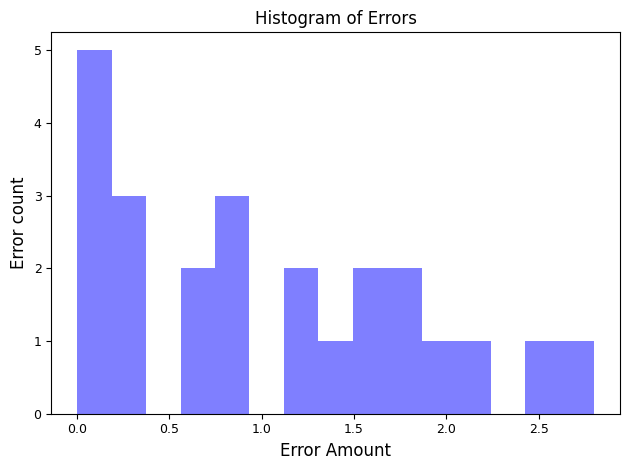

In [11]:
ẙ = AE.objective_network(X_train)
res = wuml.output_regression_result(y_train, ẙ, sort_by='error')

This is the objective network output Test error

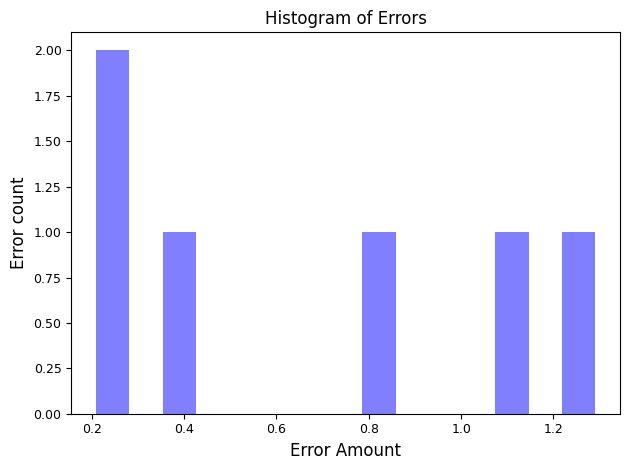

In [12]:
ẙ = AE.objective_network(X_test)
res = wuml.output_regression_result(y_test, ẙ, sort_by='error')